In [1]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

from CIFAR10_helper import *
from model import *
from common import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

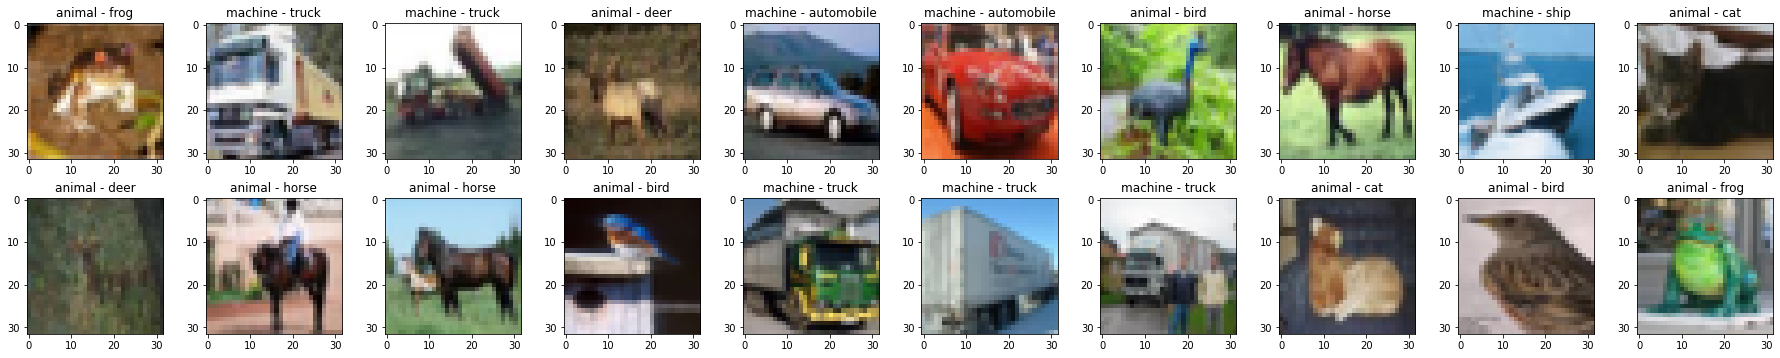

In [3]:
X, Y_super, Y_sub = get_cifar10()
plot_sample_images((X, Y_super, Y_sub), v_get_labels)

In [4]:
def create_layer(img_input, n_classes, conv_dropout=0.2, fc_dropout=0.5, activation='relu', class_type = 'default', embedding = None, nodes = 64):
    # FC Layers
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc1')(img_input)
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc2')(x)
    if embedding is not None:
        x = tf.keras.layers.Concatenate()([x, embedding])
    output = Dense(n_classes, activation='softmax', name=f'{class_type}_output')(x)
    return output, x

In [5]:
def create_model(plot=False):
    n_superclasses = 2
    n_subclasses = 10
    input_shape = x_train[0].shape

    img_input = Input(shape=input_shape, name='input')

    base_layer = vgg11(img_input,class_type = 'base')
    super_layer, super_layer_embedding = create_layer(base_layer, n_superclasses, class_type = 'super')
    sub_layer,_ = create_layer(base_layer, n_subclasses, class_type = 'sub', embedding = super_layer_embedding)

    model = keras.Model(inputs=img_input,
                 outputs = [super_layer, sub_layer],
                 name="cifar10")
    if plot:
        fig = tf.keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=75)
        display(fig)
        
    init_lr = 1e-4
    lr_decay = 1e-6
    super_weight_ratio = 0.4

    opt = keras.optimizers.Adam(lr=init_lr, decay=lr_decay)

    model.compile(
        optimizer=opt,
        loss={
            'super_output':'categorical_crossentropy',
            'sub_output':'categorical_crossentropy'
        },
        metrics={
            'super_output':'accuracy',
            'sub_output':'accuracy'
        }, 
        loss_weights=[super_weight_ratio, 1 - super_weight_ratio]
    )
    
    return model

Training on fold 0/5...


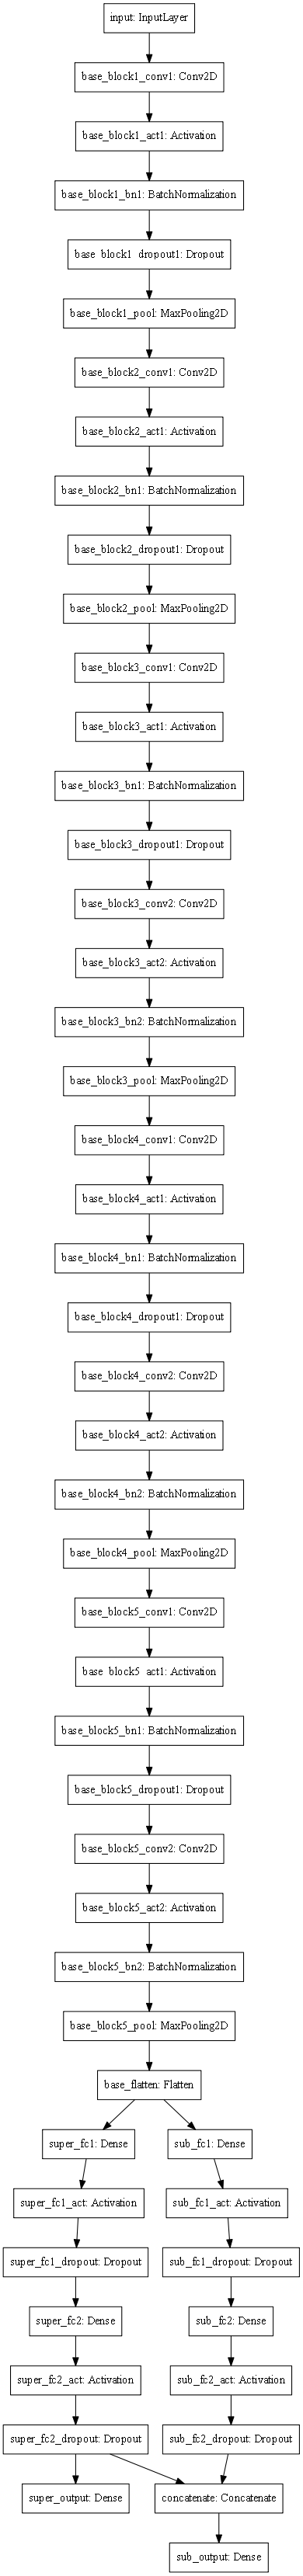

Epoch 1/80
75/75 [==============================] - 12s 108ms/step - loss: 2.0164 - super_output_loss: 0.7119 - sub_output_loss: 2.8861 - super_output_accuracy: 0.6896 - sub_output_accuracy: 0.1623 - val_loss: 1.6986 - val_super_output_loss: 0.7100 - val_sub_output_loss: 2.3577 - val_super_output_accuracy: 0.5961 - val_sub_output_accuracy: 0.0993
Epoch 2/80
75/75 [==============================] - 6s 82ms/step - loss: 1.2496 - super_output_loss: 0.3288 - sub_output_loss: 1.8634 - super_output_accuracy: 0.8654 - sub_output_accuracy: 0.3072 - val_loss: 1.9599 - val_super_output_loss: 0.9609 - val_sub_output_loss: 2.6258 - val_super_output_accuracy: 0.5961 - val_sub_output_accuracy: 0.0996
Epoch 3/80
75/75 [==============================] - 6s 80ms/step - loss: 1.1016 - super_output_loss: 0.2797 - sub_output_loss: 1.6495 - super_output_accuracy: 0.8869 - sub_output_accuracy: 0.3843 - val_loss: 2.1471 - val_super_output_loss: 1.0459 - val_sub_output_loss: 2.8812 - val_super_output_accuracy

In [6]:
stats =[]
n_splits = 5
epochs = 80
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
for index, (train_indices, val_indices) in enumerate(skf.split(X, np.zeros(len(X)))):
    print (f"Training on fold {index + 1}/{n_splits}...")
    x_train, y_super_train, y_sub_train = X[train_indices], Y_super[train_indices], Y_sub[train_indices]
    x_test, y_super_test, y_sub_test = X[val_indices], Y_super[val_indices], Y_sub[val_indices]
    model = None
    model = create_model(True if index == 0 else False)
    stats.append(train_and_predict(model, epochs, (x_train, y_super_train, y_sub_train), (x_test, y_super_test, y_sub_test)))
    reset_keras(model)

In [7]:
for i, stat in enumerate(stats):
    print(f"Fold {i + 1}: {stat}")

print("\n\nAverage [Super Class Error Rate, Sub Class Error Rate, Mismatch Rate]:")
for i in range(len(stats[0])):
    print(sum([x[i] for x in stats]) / len(stats))

Fold 0: (0.0425, 0.2405, 0.005666666666666667)
Fold 1: (0.04675, 0.25725, 0.005916666666666666)
Fold 2: (0.051916666666666667, 0.2699166666666667, 0.004666666666666667)
Fold 3: (0.04566666666666667, 0.249, 0.005916666666666666)
Fold 4: (0.042916666666666665, 0.22966666666666666, 0.007166666666666667)


Average [Super Class Error Rate, Sub Class Error Rate, Mismatch Rate]:
0.04595
0.24926666666666666
0.005866666666666668
